# Can we relate chemical data to morphological data?

In [2]:
import pandas as pd
import numpy as np
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

In [3]:
import sys
sys.path.insert(0, '/Users/spoelsterl/Projects/ICR/pyfda/')

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
from pyfda import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy.cluster import hierarchy

In [6]:
def get_features(filename, groups = ['Cells', 'Cytoplasm', 'Nuclei']):
    df = pd.read_csv(filename)
    cols = np.zeros(df.shape[1], dtype=bool)
    for g in groups:
        cols |= df.columns.str.startswith(g)

    def _get_name(row):
        if row['Metadata_broad_sample'] == 'DMSO':
            return 'DMSO_%s_%s' % (row['Metadata_Plate'], row['Metadata_Well'])
        else:
            return row['Metadata_broad_sample']

    index_s = df.apply(_get_name, axis=1, reduce=True)
    index_s.name = 'Metadata_sample'
    data = pd.concat((df['Metadata_Plate'], index_s, df.loc[:, cols]), axis=1)
    data.set_index(['Metadata_Plate', 'Metadata_sample'], inplace=True)
    return data

In [7]:
def get_features2(filename, groups = ['Cells', 'Cytoplasm', 'Nuclei']):
    df = pd.read_csv(filename).iloc[1:, :]
    cols = np.zeros(df.shape[1], dtype=bool)
    for g in groups:
        cols |= df.columns.str.startswith(g)

    def _get_name(row):
        if row['Metadata_broad_sample'] == 'DMSO':
            return 'DMSO_%s_%s' % (row['Metadata_Plate'], row['Metadata_Well'])
        else:
            return row['Metadata_broad_sample']

    index_s = df.apply(_get_name, axis=1, reduce=True)
    index_s.name = 'Metadata_sample'
    data = pd.concat((df['Metadata_Plate'], index_s, df.loc[:, cols]), axis=1)
    data.set_index(['Metadata_Plate', 'Metadata_sample'], inplace=True)
    return data

In [29]:
files = glob('bbbc022/*.csv')

In [30]:
data = [get_features(f) for f in files]
data = pd.concat(data)

In [8]:
#data = get_features2('marie_profile.csv')

In [31]:
pipeline = Pipeline([
    ('useless', preprocessing.UselessFeatureFilter()),
    ('standardize', StandardScaler())
])
data_t = pipeline.fit_transform(data)

In [32]:
def to_flat(Z, n_clusters):
    assignments = hierarchy.cut_tree(Z, n_clusters=n_clusters).flatten()
    return assignments

In [33]:
# %load enrichment_score.py
import numpy
import pandas as pd
from rpy2.robjects import pandas2ri, packages
from scipy.stats import percentileofscore
from sklearn.utils.validation import check_random_state


def enrichment_score(clusters, labels, data, n_repeat=1000, random_state=None, adjust="BH"):
    """Compute percentage of labels in each cluster and compare it
    against the null hypothesis that labels are randomly assigned to clusters

    The p-value corresponds to the probability to observe a support larger or
    equal to the one according to the current cluster assignments,
    i.e., the p-value is one-tailed.

    :param clusters: Name of column containing cluster assignments
    :param labels: Name of column containing labels
    :param data: Data frame containing cluster assignments and labels
    :type data: pd.DataFrame
    :param n_repeat: Number of permutations used to determine distribution under null hypothesis
    :param random_state: Random number seed
    :param adjust: Method to use to adjust p-values (see R's p.adjust function)
    :returns: For each cluster, the abundance of labels and its associated p-value
    :rtype: pd.DataFrame
    """
    total_counts = data[labels].value_counts()

    def get_support(x, expand=False):
        c = x.value_counts().astype(float)
        for i in c.index:
            c.loc[i] /= total_counts.loc[i]

        if expand:
            c = c.loc[total_counts.index]
            c.fillna(0, inplace=True)
        return c

    cluster_counts = data.groupby(clusters)[labels].apply(get_support)

    rnd = check_random_state(random_state)
    rnd_data = data.copy()
    rnd_labels = data[labels].values

    null_counts = pd.DataFrame(index=pd.MultiIndex.from_product(
                                   [data[clusters].unique(), data[labels].unique()]),
                               columns=numpy.arange(n_repeat))
    # permute cluster labels
    for i in range(n_repeat):
        rnd.shuffle(rnd_labels)
        rnd_data[labels] = rnd_labels
        rnd_counts = rnd_data.groupby(clusters)[labels].apply(
            lambda x: get_support(x, expand=True))
        null_counts.iloc[:, i] = rnd_counts

    pvals = pd.Series(index=cluster_counts.index)
    for ind, score in cluster_counts.iteritems():
        # compute P(X < score)
        p = percentileofscore(null_counts.xs(ind).values, score, kind="strict")
        pvals[ind] = (100 - p) / 100.

    # Adjust P-values for Multiple Comparisons
    _stats = packages.importr("stats")
    pandas2ri.activate()
    padj_arr = numpy.asarray(_stats.p_adjust(pvals.values, method=adjust))
    pandas2ri.deactivate()

    padj = pd.Series(padj_arr, index=cluster_counts.index)

    df = pd.DataFrame.from_items([("support", cluster_counts),
                                  ("p-value", pvals),
                                  ("p-adjusted ({})".format(adjust), padj)])
    return df


## Annotation labels

In [34]:
#data_annotated = pd.read_table('H-BIOA-002.compounds.normalized.annotated.L123.txt', sep='\t')
data_annotated = pd.read_table('H-BIOA-002.compounds.normalized.annotated.all.txt', sep='\t')
data_annotated = data_annotated.loc[:, ['broad_sample', 'compound_annotation_value']]
data_annotated = data_annotated.groupby('broad_sample').first().reset_index()
# counts = data_annotated.broad_sample.value_counts()
# no_multi = set((counts[counts == 1]).index)
# m = data_annotated.loc[:, 'broad_sample'].isin(no_multi)
# data_annotated = data_annotated.loc[m, :]

In [35]:
data_merged = pd.merge(data.index.to_frame(), data_annotated,
                       how="left",
                       left_on="Metadata_sample",
                       right_on="broad_sample").set_index(data.index.names).loc[:, 'compound_annotation_value']

In [36]:
is_control = data_merged.index.to_frame().loc[:, 'Metadata_sample'].str.startswith('DMSO')
#is_control = pd.Series(is_control, index=data_merged.index)
data_merged.loc[is_control] = 'control'
data_merged.fillna('unknown', inplace=True)

## Auto-encoder

In [37]:
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model

In [62]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

n_features = data_t.shape[1]
# this is our input placeholder
input_img = Input(shape=(n_features,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# encoded = Dense(64, activation='relu',
#                 activity_regularizer=regularizers.l1(10e-5))(encoded)
# encoded = Dense(encoding_dim, activation='relu',
#                 activity_regularizer=regularizers.l1(10e-5))(encoded)

# "decoded" is the lossy reconstruction of the input
# decoded = Dense(64, activation='sigmoid')(encoded)
# decoded = Dense(128, activation='sigmoid')(encoded)
decoded = Dense(n_features, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
x_train, x_test = train_test_split(data_t, test_size=0.1, random_state=29)

In [65]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 6912 samples, validate on 768 samples
Epoch 1/50
6912/6912 [==============================] - 0s - loss: 0.5749 - val_loss: 0.2555
Epoch 2/50
6912/6912 [==============================] - 0s - loss: -0.4020 - val_loss: -1.3367
Epoch 3/50
6912/6912 [==============================] - 0s - loss: -2.2809 - val_loss: -2.8544
Epoch 4/50
6912/6912 [==============================] - 0s - loss: -3.1745 - val_loss: -3.2508
Epoch 5/50
6912/6912 [==============================] - 0s - loss: -3.5076 - val_loss: -3.5162
Epoch 6/50
6912/6912 [==============================] - 0s - loss: -3.7797 - val_loss: -3.7596
Epoch 7/50
6912/6912 [==============================] - 0s - loss: -4.0195 - val_loss: -3.9545
Epoch 8/50
6912/6912 [==============================] - 0s - loss: -4.2038 - val_loss: -4.0946
Epoch 9/50
6912/6912 [==============================] - 0s - loss: -4.3375 - val_loss: -4.1985
Epoch 10/50
6912/6912 [==============================] - 0s - loss: -4.4377 - val_loss: -4.2776
Epoc

In [66]:
data_encoded = encoder.predict(data_t, batch_size=256)

In [84]:
s_labels, s_data = labels[labels != 'unknown'].align(data, join='inner')

In [89]:
data_encoded = encoder.predict(pipeline.transform(s_data), batch_size=256)
data = s_data

# Annotation overlay

In [90]:
link_mat = hierarchy.linkage(data_encoded, method='average')

In [91]:
n_clusters = 10
clusters = pd.Series(to_flat(link_mat, n_clusters),
                     index=data.index,
                     name='assignment')
clusters.value_counts()

0    3908
1      57
2      29
5      11
4       6
6       5
3       4
7       2
9       1
8       1
Name: assignment, dtype: int64

In [92]:
labels = s_labels

In [93]:
scores = enrichment_score(labels.name, clusters.name, pd.concat((clusters, labels), axis=1), n_repeat=500)

In [94]:
scores.sort_values(by='p-adjusted (BH)').head(25)

support  p-value  \
compound_annotation_value                                                 
control                                            0  0.327533    0.000   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    5  0.818182    0.000   
                                                   2  0.724138    0.000   
                                                   1  0.789474    0.000   
Enzyme:Kinase:Protein_Kinase                       1  0.087719    0.000   
Ion_channel:Voltage-gated_ion_channel:Potassium... 9  1.000000    0.008   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    6  1.000000    0.010   
Enzyme:Kinase:Protein_Kinase                       2  0.103448    0.020   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    4  0.833333    0.028   
Membrane_receptor:Family_A_G_protein-coupled_re... 5  0.181818    0.046   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_2    0  0.100563    0.096   
Enzyme:Oxidoreductase:None                         0  0.018424    0.106   
Enzyme:None:None                                   1  0.070175    0.120   
Enzyme:Protease:Aspartic_protease                  2  0.034483    0.134   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    7  1.000000    0.160   
                                                   3  0.750000    0.158   
Enzyme:Cytochrome_P450:Cytochrome_P450_family_3    0  0.013306    0.206   
Enzyme:None:None                                   2  0.068966    0.244   
Ion_channel:Ligand-gated_ion_channel:P2X_receptor  0  0.001024    0.874   
Ion_channel:Ligand-gated_ion_channel:GABA-A_rec... 0  0.008188    0.398   
Ion_channel:Voltage-gated_ion_channel:Voltage-g... 0  0.001024    0.894   
Ion_channel:Ligand-gated_ion_channel:Ionotropic... 0  0.002047    0.786   
Ion_channel:Voltage-gated_ion_channel:Potassium... 0  0.009980    0.680   
Ion_channel:Ligand-gated_ion_channel:Nicotinic_... 0  0.002047    0.804   
Other_cytosolic_protein:None:None                  0  0.002047    0.796   

                                                      p-adjusted (BH)  
compound_annotation_value                                              
control                                            0         0.000000  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    5         0.000000  
                                                   2         0.000000  
                                                   1         0.000000  
Enzyme:Kinase:Protein_Kinase                       1         0.000000  
Ion_channel:Voltage-gated_ion_channel:Potassium... 9         0.088000  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    6         0.094286  
Enzyme:Kinase:Protein_Kinase                       2         0.165000  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    4         0.205333  
Membrane_receptor:Family_A_G_protein-coupled_re... 5         0.303600  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_2    0         0.576000  
Enzyme:Oxidoreductase:None                         0         0.583000  
Enzyme:None:None                                   1         0.609231  
Enzyme:Protease:Aspartic_protease                  2         0.631714  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_1    7         0.660000  
                                                   3         0.660000  
Enzyme:Cytochrome_P450:Cytochrome_P450_family_3    0         0.799765  
Enzyme:None:None                                   2         0.894667  
Ion_channel:Ligand-gated_ion_channel:P2X_receptor  0         0.970839  
Ion_channel:Ligand-gated_ion_channel:GABA-A_rec... 0         0.970839  
Ion_channel:Voltage-gated_ion_channel:Voltage-g... 0         0.970839  
Ion_channel:Ligand-gated_ion_channel:Ionotropic... 0         0.970839  
Ion_channel:Voltage-gated_ion_channel:Potassium... 0         0.970839  
Ion_channel:Ligand-gated_ion_channel:Nicotinic_... 0         0.970839  
Other_cytosolic_protein:None:None                  0         0.970839

In [96]:
u = list(labels.unique())
palette = sns.palettes.color_palette('Dark2', n_colors=len(u))
colors = pd.Series([palette[u.index(l)] for l in labels], index=data.index)

In [97]:
from sklearn.decomposition import PCA

In [98]:
data_pca = PCA(n_components=2).fit_transform(data_encoded)

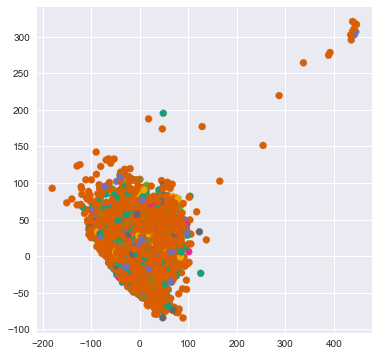

In [99]:
%matplotlib inline
plt.figure(figsize=(6, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=colors)
plt.savefig('pca-no-unknown.pdf', bbox_inches='tight')

In [102]:
labels[dd.index]

Metadata_Plate  Metadata_sample       
20586           BRD-A18497530-001-04-6                       Enzyme:Kinase:Protein_Kinase
                BRD-K01292756-001-06-0    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
                BRD-K15519488-001-01-6    Enzyme:Cytochrome_P450:Cytochrome_P450_family_2
                BRD-K50135270-001-01-9    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
20589           BRD-A62336480-001-02-5    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
                BRD-K94512704-001-02-1    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
20592           BRD-K87904882-001-02-3    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
20593           BRD-A26334849-001-02-1    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
                BRD-K45662124-001-01-8    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
                BRD-K77947974-001-04-9    Enzyme:Cytochrome_P450:Cytochrome_P450_family_1
                BRD-K89732114-001-03-4    Enzyme:Cytochrome_P

/Users/spoelsterl/miniconda3/envs/micro/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


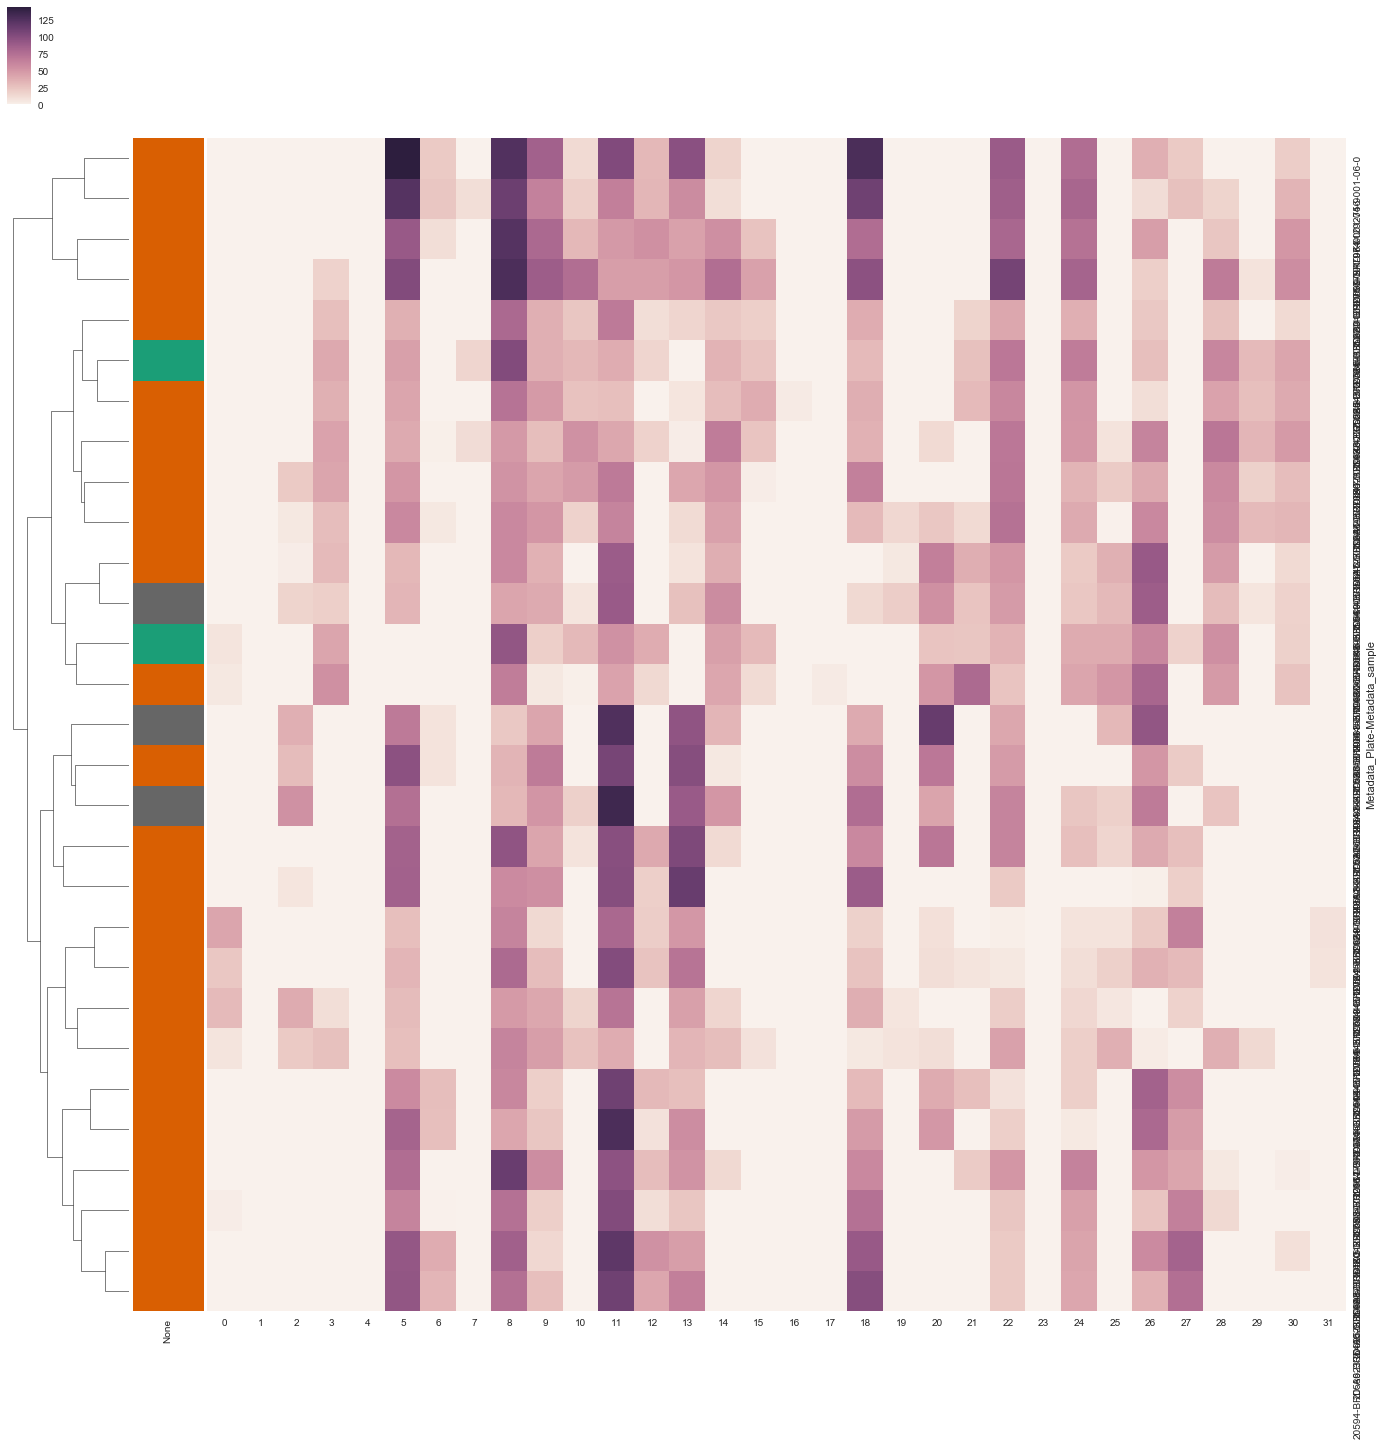

In [100]:
%matplotlib agg
df_encoded = pd.DataFrame(data_encoded, index=data.index)
dd = df_encoded.loc[clusters[clusters == 2].index, :]

g = sns.clustermap(dd, col_cluster=False, row_colors=colors[dd.index],
                   figsize=(24, 24),)
plt.savefig('cluster-no-unknown-2.pdf', bbox_inches='tight')

In [72]:
%matplotlib agg
g = sns.clustermap(data_encoded, row_linkage=link_mat, col_cluster=False,
                   figsize=(64, 64))
plt.savefig('cluster.pdf', bbox_inches='tight')

/Users/spoelsterl/miniconda3/envs/micro/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


KeyboardInterrupt: 